In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE


In [2]:
!pip install meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 3.7 MB/s eta 0:00:00


In [3]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2024-10-09 14:51:38--  https://fem-on-colab.github.io/releases/firedrake-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4581 (4.5K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.47K  --.-KB/s    in 0s      

2024-10-09 14:51:38 (74.7 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4581/4581]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/69d91d8/rele

/usr/local/lib/python3.10/dist-packages/pytools/persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


# Mesh Plots

In [32]:
import meshio
import matplotlib.pyplot as plt

In [33]:
mesh = meshio.read(
    'testairfoil.msh'
)

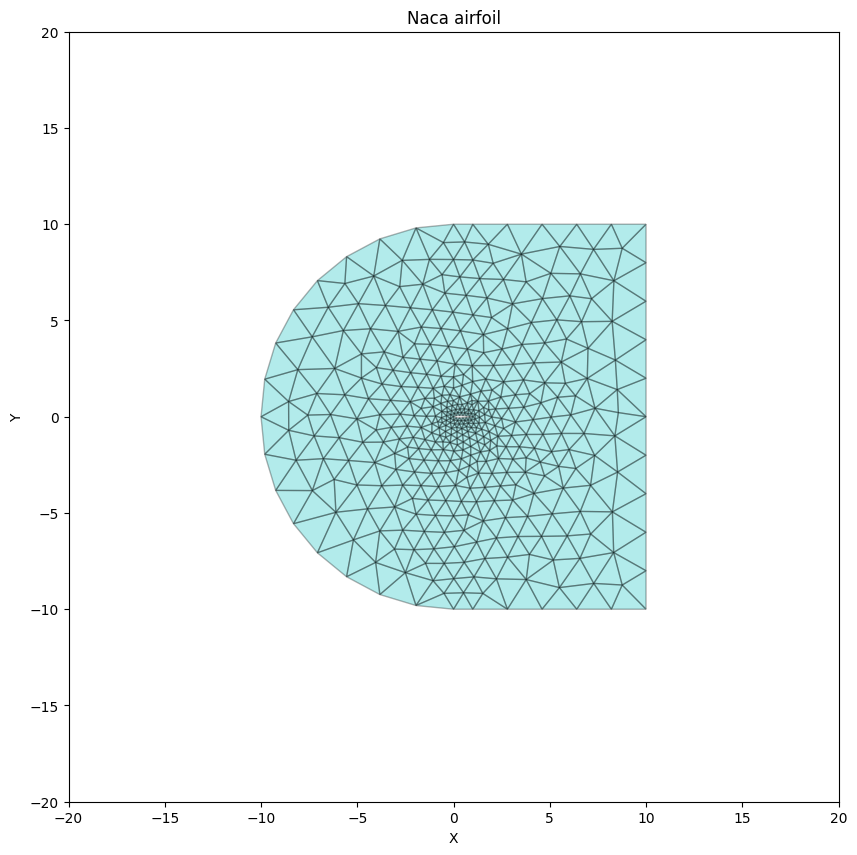

In [34]:
# Extract points and cells
points = mesh.points
cells = mesh.cells_dict

# Extract triangle faces (if available)
triangles = cells.get('triangle', [])

# Create a figure with a larger size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the mesh
if len(triangles) > 0:
    # Unpacking triangle vertex indices
    triangle_vertices = points[triangles]
    for triangle in triangle_vertices:
        polygon = plt.Polygon(triangle[:, :2], edgecolor='k', facecolor='c', alpha=0.3)
        ax.add_patch(polygon)
    #ax.plot(points[:, 0], points[:, 1], '.', markersize=1)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Naca airfoil')
ax.set_aspect('equal')

# Set axis limits if needed to zoom into the area of interest
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)

# Show the plot
plt.show()


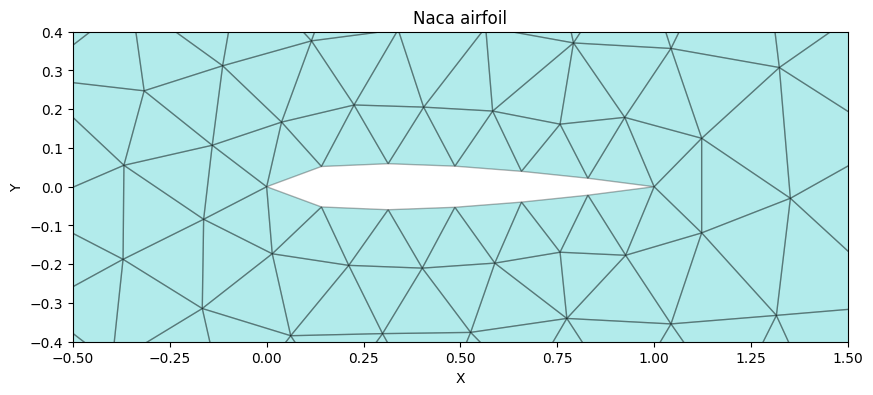

In [35]:

# Extract points and cells
points = mesh.points
cells = mesh.cells_dict

# Extract triangle faces (if available)
triangles = cells.get('triangle', [])

# Create a figure with a larger size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the mesh
if len(triangles) > 0:
    # Unpacking triangle vertex indices
    triangle_vertices = points[triangles]
    for triangle in triangle_vertices:
        polygon = plt.Polygon(triangle[:, :2], edgecolor='k', facecolor='c', alpha=0.3)
        ax.add_patch(polygon)
    #ax.plot(points[:, 0], points[:, 1], '.', markersize=1)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Naca airfoil')
ax.set_aspect('equal')

# Set axis limits if needed to zoom into the area of interest
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.4, 0.4)

# Show the plot
plt.show()


# Solve stokes to obtain a starting point

In [10]:
from firedrake import *
import matplotlib.pyplot as plt

In [11]:
M = Mesh('testairfoil.msh')

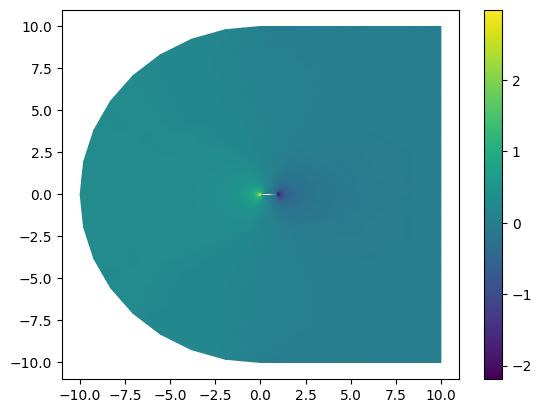

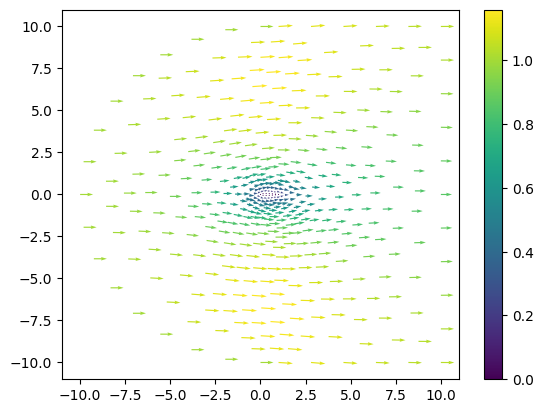

In [12]:
# function space
V=VectorFunctionSpace(M, 'P', 2) # velocity
Q=FunctionSpace(M, 'P', 1) # pressure
W=MixedFunctionSpace([V, Q])

# trial and test functions
u, p=TrialFunctions(W)
v, q=TestFunctions(W)

# data
x=SpatialCoordinate(M)
Uinf=as_vector([1,0])

# problem
a=inner(grad(u), grad(v))*dx - p*div(v)*dx+ q*div(u)*dx
L=inner(Constant((0,0)),v)*dx

# Dirichlet BC
bc1=DirichletBC(W.sub(0), as_vector([0,0]), 0)
bc2=DirichletBC(W.sub(0), Uinf, 1)
bcs=(bc1, bc2)

#solution
w_stokes=Function(W)
solve(a==L, w_stokes, bcs=bcs)
# u_h, p_h=split(wh) no split command works only for trial and test funtion
u_stokes, p_stokes=w_stokes.subfunctions

fig, ax = plt.subplots()
q=tripcolor(p_stokes, axes=ax)
fig.colorbar(q)
fig, ax = plt.subplots()
q=quiver(u_stokes, axes=ax)
fig.colorbar(q)

# Set Reynolds Number


In [13]:
Re = Constant(3500)

# Solve Navier Stokes with the initial guess

In [14]:
# Adimensionalized formulation for high Re
def functional_high_Re(uh, v, ph, q, Re, f):
    G = inner(dot(grad(uh), uh), v) * dx  \
        +  1/Re * inner(grad(uh), grad(v)) * dx  \
        - div(v) * ph * dx  \
        + q * div(uh) * dx \
        - inner(f, v) * dx
    return G

# Adimensionalized formulation for low Re
def functional_low_Re(uh, v, ph, q, Re, f):
    G = Re * inner(dot(grad(uh), uh), v) * dx  \
        +  inner(grad(uh), grad(v)) * dx  \
        - div(v) * ph * dx  \
        + q * div(uh) * dx \
        - inner(f, v) * dx
    return G

In [15]:
# Function spaces (mixed formulation)
V = VectorFunctionSpace(M, 'P', 2)
Q = FunctionSpace(M, 'P', 1)
W = MixedFunctionSpace([V, Q])

# Data and boundary conditions
f = Constant((0.,0.))

u_in = as_vector([1., 0.])

bc1 = DirichletBC(W.sub(0), Constant((0.,0.)), 0) # Dirichlet no-slip B.C. on the airfoil
bc2 = DirichletBC(W.sub(0), u_in, 1) # Dirichlet unitary B.C. on the inflow boundary

bcs = (bc1, bc2)

In [16]:
# Trial and test functions
wh = Function(W)
uh, ph = split(wh) # trial functions
v, q = TestFunctions(W) # test functions
#w=Function(W)
#v, q=split(w)

# Setting the problem
G = functional_high_Re(uh, v, ph, q, Re, f)


In [17]:
wh.assign(w_stokes)
param = {'ksp_type':'gmres',
         'ksp_pc_type':'mumps',
         'ksp_maxit':1000,
         'ksp_rtol':1e-8,
         'snes_rtol':1e-3,
         'snes_maxit':100,
       }
nsp = MixedVectorSpaceBasis(
    W, [W.sub(0), VectorSpaceBasis(constant=True)])

solve(G == 0, wh, bcs=bcs, solver_parameters=param)

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


## Plotting the solution

In [18]:
uh, ph = wh.subfunctions
outfileU = File("output/velocity.pvd")
outfileP = File("output/pressure.pvd")
uh.rename("Velocity")   # this name will be used in Paraview
ph.rename("Pressure")   # this name will be used in Paraview
outfileU.write(uh)
outfileP.write(ph)


/Users/guidopoletti/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


(-3.0, 3.0)

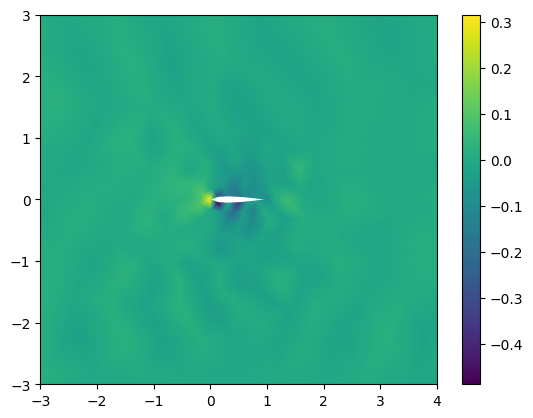

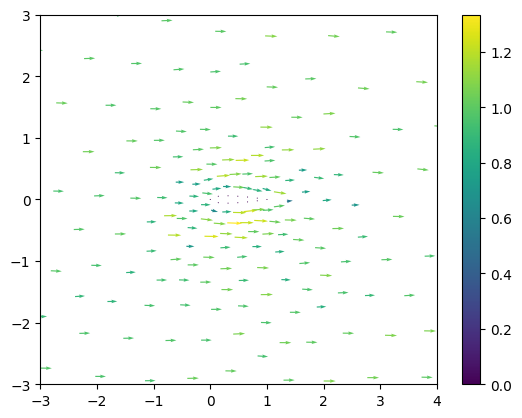

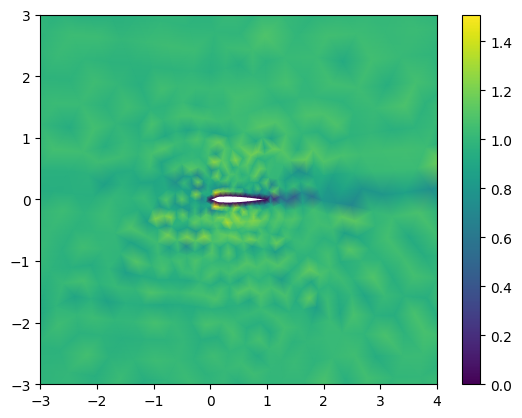

In [19]:
u_h, p_h = wh.subfunctions
fig, ax = plt.subplots()
q=tripcolor(p_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=quiver(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=tripcolor(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

# Solve Navier Stokes with SUPG Stabilization

In [20]:
def a(u,v, Re):
    return 1/Re*inner(grad(u), grad(v))*dx

def c(w,u,v):
    return inner(dot(grad(u), w),v)*dx

def b(v,q):
    return -q*div(v)*dx

def stabilization(u_old, u, p, v, q, M, Re):
    ubar = Function(FunctionSpace(M, 'DG', 0))
    ubar.project(sqrt(inner(u_old, u_old)))
    h = CellDiameter(M)
    Re_K = h * ubar * Re
    one  = Constant(1.0)
    delta_K = delta * conditional(gt(Re_K, one),  h/(ubar+1e-5), h*h*Re)

    L= -1.0/Re*div(grad(u))+ dot(grad(u_old), u) + dot(grad(u), u_old)+ grad(p)
    Lss = dot(grad(u_old),v) + dot(grad(v),u_old) + grad(q)

    lhs= delta_K * inner(L, Lss)*dx + delta_K*div(u)*div(v)*dx
    rhs=delta_K*inner(dot(grad(u_old), u_old), Lss)*dx

    return lhs, rhs


In [21]:
# Function spaces (mixed formulation)
V = VectorFunctionSpace(M, 'P', 2)
Q = FunctionSpace(M, 'P', 1)
W = MixedFunctionSpace([V, Q])

# Data and boundary conditions
f = Constant((0.,0.))

u_in = as_vector([1., 0.])

bc1 = DirichletBC(W.sub(0), Constant((0.,0.)), 0) # Dirichlet no-slip B.C. on the airfoil
bc2 = DirichletBC(W.sub(0), u_in, 1) # Dirichlet unitary B.C. on the inflow boundary

bcs = (bc1, bc2)

In [22]:
# Trial and test functions
u, p = TrialFunctions(W) # trial functions
v, q = TestFunctions(W) # test functions

# solution
wh = Function(W)
uh, ph = wh.subfunctions
wh.assign(w_stokes) #initialization with stokes solution

maxit=100
tol=1e-8
it=0
err=tol+1
delta=1

u_old = Function(V)
u_old.assign(uh)
p_old = Function(Q)
p_old.assign(ph)

while it < maxit and err > tol:
  lhs, rhs = stabilization(u_old, u, p, v, q, M, Re)
  G = a(u,v,Re) + c(u,u_old,v)+c(u_old,u,v)-b(u,q)+b(v,p)+lhs
  L = inner(f,v)*dx +rhs + c(u_old, u_old,v)
  pb = LinearVariationalProblem(G, L , wh, bcs=bcs)
  solver = LinearVariationalSolver(pb)
  solver.solve()
  uh, ph = wh.subfunctions
  err = (errornorm(uh, u_old, 'H1') / norm(u_old, 'H1') + errornorm(ph, p_old, 'L2') / norm(p_old, 'L2'))
  u_old.assign(uh)
  p_old.assign(ph)
  it+=1

print(it)

16


## Plotting the solution

In [23]:
uh, ph = wh.subfunctions
outfileU = File("output/velocity.pvd")
outfileP = File("output/pressure.pvd")
uh.rename("Velocity")   # this name will be used in Paraview
ph.rename("Pressure")   # this name will be used in Paraview
outfileU.write(uh)
outfileP.write(ph)

/Users/guidopoletti/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


(-3.0, 3.0)

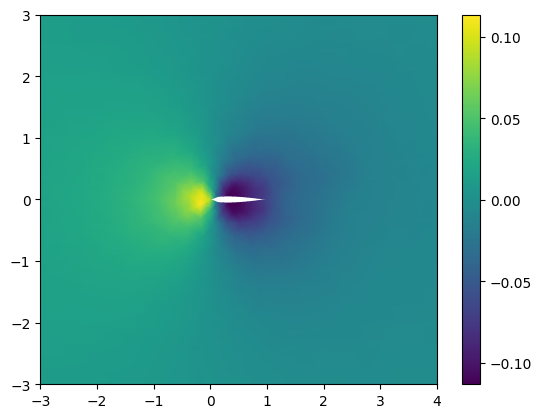

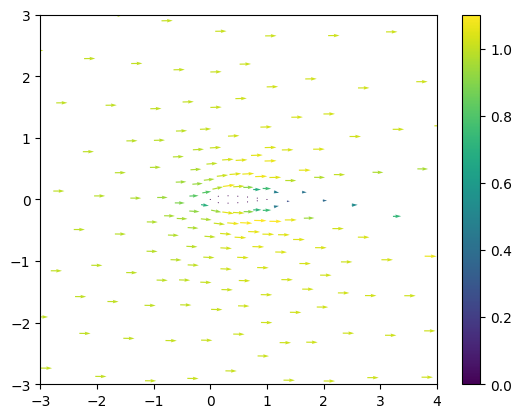

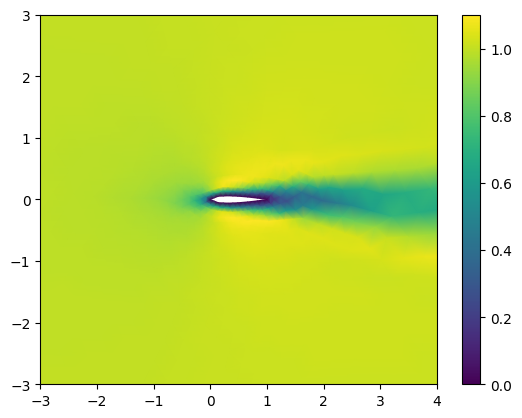

In [24]:
u_h, p_h = wh.subfunctions
fig, ax = plt.subplots()
q=tripcolor(p_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=quiver(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=tripcolor(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)